In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from matplotlib.gridspec import GridSpec


In [4]:
(train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, Pool_X, train_y,  Pool_y = train_test_split(train_pool_X, train_pool_y, train_size=50, random_state=42)
print(train_X.shape, Pool_X.shape, train_y.shape, Pool_y.shape, test_X.shape, test_y.shape)


(50, 28, 28) (59950, 28, 28) (50,) (59950,) (10000, 28, 28) (10000,)


In [5]:
train_pool_X = train_pool_X.reshape(train_pool_X.shape[0], -1)
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
Pool_X = Pool_X.reshape(Pool_X.shape[0], -1)
print(train_pool_X.shape, train_X.shape, test_X.shape, Pool_X.shape)

(60000, 784) (50, 784) (10000, 784) (59950, 784)


In [6]:
model = LogisticRegression(max_iter=10000)


In [7]:
def add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample=1,seed=0):
    np.random.seed(seed)
    random_indices = np.random.choice(pool_X_train.shape[0], size=number_of_sample, replace=False)
    labeled_X = pool_X_train[random_indices]
    labeled_y = pool_y_train[random_indices]
    train_X = np.concatenate((train_X, labeled_X), axis=0)
    train_y = np.concatenate((train_y, labeled_y), axis=0)
    pool_X_train = np.delete(pool_X_train, random_indices, axis=0)
    pool_y_train = np.delete(pool_y_train, random_indices)
    return train_X, train_y, pool_X_train, pool_y_train

In [47]:
def active_learning_sampling(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test,num_iterations=3, number_of_sample=1,seed=0):
    accuracy_iteration = []
    for _ in range(num_iterations):
        model = LogisticRegression()
        train_X, train_y, pool_X_train, pool_y_train = add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample,seed)
        model.fit(train_X, train_y)
        y_pred = model.predict(pool_X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_iteration.append(accuracy)
        
    accuracy_iteration = np.array(accuracy_iteration)
    mean_accuracy = np.mean(accuracy_iteration)
    std_accuracy = np.std(accuracy_iteration)
    return accuracy_iteration , mean_accuracy, std_accuracy

In [55]:
num_iterations = 50
num_seeds = 50  
iterations = range(1, num_iterations + 1)

mean_accuracy_all_seeds = []
std_accuracy_all_seeds = []

for seed in range(42, 42 + num_seeds):
    accuracy_after_random_sampling, _, _ = active_learning_sampling(train_X, train_y, Pool_X, Pool_y, test_X, test_y, num_iterations, 1, seed)
    mean_accuracy_all_seeds.append(np.mean(accuracy_after_random_sampling))
    std_accuracy_all_seeds.append(np.std(accuracy_after_random_sampling))

mean_accuracy_all_seeds = np.array(mean_accuracy_all_seeds)
std_accuracy_all_seeds = np.array(std_accuracy_all_seeds)
mean_accuracy_all_seeds = np.round(mean_accuracy_all_seeds, 3)
std_accuracy_all_seeds = np.round(std_accuracy_all_seeds, 3)
print(mean_accuracy_all_seeds)
print(std_accuracy_all_seeds)


[0.707 0.718 0.707 0.7   0.712 0.702 0.717 0.715 0.713 0.713 0.705 0.709
 0.7   0.691 0.675 0.71  0.701 0.715 0.675 0.687 0.7   0.709 0.727 0.722
 0.721 0.704 0.705 0.686 0.692 0.702 0.719 0.708 0.698 0.708 0.719 0.694
 0.697 0.699 0.709 0.713 0.694 0.672 0.701 0.698 0.672 0.699 0.698 0.684
 0.7   0.684]
[0.036 0.038 0.019 0.012 0.02  0.022 0.03  0.026 0.03  0.025 0.017 0.016
 0.009 0.022 0.015 0.027 0.027 0.031 0.006 0.025 0.02  0.018 0.034 0.028
 0.021 0.024 0.012 0.011 0.018 0.021 0.025 0.027 0.019 0.02  0.021 0.022
 0.019 0.023 0.024 0.017 0.012 0.015 0.021 0.027 0.019 0.018 0.015 0.018
 0.025 0.016]


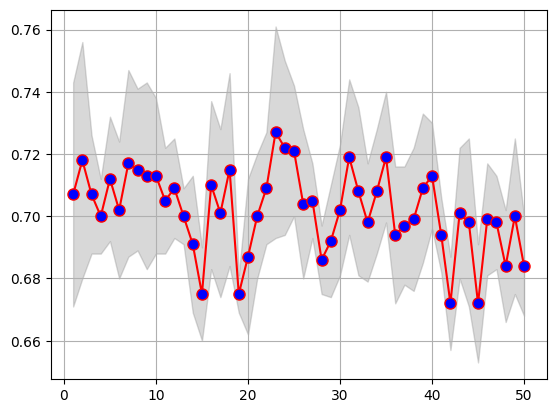

In [56]:
plt.plot(iterations, mean_accuracy_all_seeds,color='red', label='Mean accuracy',marker='o',markersize=8, markerfacecolor='blue')
plt.fill_between(iterations, mean_accuracy_all_seeds - std_accuracy_all_seeds, mean_accuracy_all_seeds + std_accuracy_all_seeds, alpha=0.3, color='gray', label='Standard deviation')
plt.grid()

In [84]:
def random_sample(p,number_of_sample=1):
    num_samples = p.shape[0]
    sample = np.random.choice(num_samples, size=number_of_sample, replace=False)
    return sample

In [85]:
def entropy(p):
    return -np.sum(p * np.log2(p), axis=1)

In [94]:
def margin_sampling(probabilities):
    sorted_probs = np.sort(probabilities, axis=1)
    return 1 - np.max(probabilities, axis=1) - sorted_probs[:, -2]

In [95]:
def least_confident(probabilities):
    return 1 - np.max(probabilities, axis=1)

In [111]:

def active_learning(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, acquisition_function, num_iterations, number_of_sample=1):
    new_indices_list = []
    accuracy_iteration = []

    for _ in range(num_iterations):
        model = LogisticRegression(max_iter=10000)
        model.fit(train_X, train_y)

        pool_probabilities = model.predict_proba(pool_X_train)
        acquisition_scores = acquisition_function(pool_probabilities)

        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]

        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]
        
        new_indices_list.append(selected_indices)

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)

        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)
        
        
        y_pred = model.predict(pool_X_test)
        accuracy = accuracy_score(y_test, y_pred)
        # print("Accuracy score after iteration {}: {:.4f} ".format(_ + 1, accuracy))

        accuracy_iteration.append(accuracy)

    return  accuracy_iteration , new_indices_list


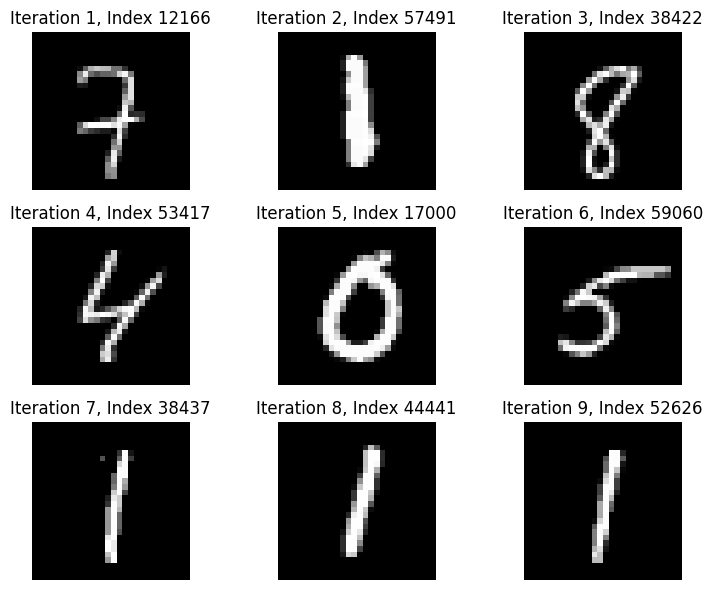

In [134]:
accuracy_least_random,new_indices_list = active_learning(train_X, train_y, Pool_X, Pool_y, test_X, test_y, acquisition_function=entropy, num_iterations=9, number_of_sample=1)
num_rows =  3
num_cols = 3

grid = GridSpec(num_rows, num_cols,figure=fig)
fig = plt.figure(figsize=(8, 6))

for i in range(num_rows):
    for j in range(num_cols):
        idx = new_indices_list[i * num_cols + j][0]
        ax = fig.add_subplot(grid[i, j])
        ax.imshow(Pool_X[idx].reshape(28, 28), cmap='gray') 
        ax.set_title(f'Iteration {i * num_cols + j + 1}, Index {idx}')
        ax.axis('off')
plt.tight_layout()


In [102]:
accuracy_least_random = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y, acquisition_function=random_sample,
                                                                                                 num_iterations=70,
                                                                                                 number_of_sample=10)

In [103]:
accuracy_least_entropy = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y, acquisition_function=entropy,
                                                                                                 num_iterations=70,
                                                                                                 number_of_sample=10)

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [104]:
accuracy_least_margin = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=margin_sampling,
                                                                                                 num_iterations=70,
                                                                                                 number_of_sample=10)

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [105]:
accuracy_confident = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=least_confident,
                                                                             num_iterations=70,
                                                                             number_of_sample=10)

/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rishabh.mondal/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

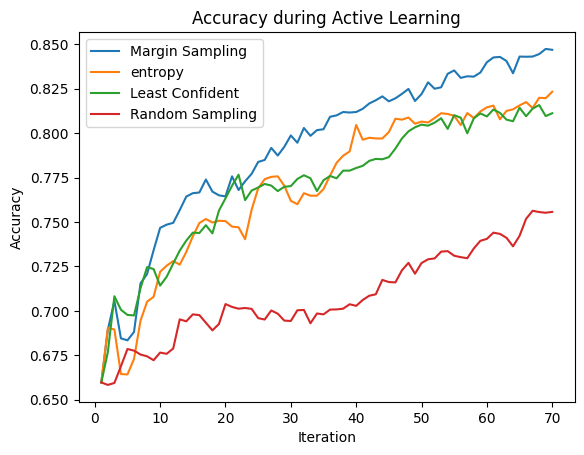

In [106]:
plt.plot(range(1, len(accuracy_least_margin) + 1), accuracy_least_margin,label='Margin Sampling')
plt.plot(range(1, len(accuracy_least_entropy) + 1), accuracy_least_entropy, label='entropy')
plt.plot(range(1, len(accuracy_confident) + 1), accuracy_confident,label='Least Confident')
plt.plot(range(1, len(accuracy_least_random) + 1), accuracy_least_random,label='Random Sampling')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy during Active Learning')
plt.legend();